# Assignment 5

In this assignment, we'll finally work with some nonconjugate models. I will also introduce you to reparameterization techniques.

## Instructions

Please complete this Jupyter notebook and **don't** convert it to a `.py` file. Upload this notebook, along with any `.stan` files and any data sets as a `zip` file to Gradescope. 

Your work will be manually graded by our TA. There is no autograder for this assignment. For free response questions, feel free to add a markdown cell and type in there. Try to keep the preexisting structure as much as possible, and to be organized and label which cells correspond with which questions.



### Problem 1: Poisson Data

In the last assignment, we modeled a vector of counts $y = (y_1, \ldots, y_n)$ using a multinomial distribution. 

Unlike last time, all of these counts will now assumed to be independent. Further, we can't reasonably put a bound on what each count could be. So, in this problem, we'll use a **Poisson likelihood**:

$$
L(y \mid \theta) = \prod_{i=1}^n L(y_i \mid \theta) \propto \prod_{i=1}^n e^{-\theta}\theta^{y_i} = e^{-n\theta}\theta^{\sum_i y_i}
$$

With this likelihood, $\theta > 0$ is interpreted as a rate or average.

The data can be found in `Road_Casualties_in_Great_Britain_1969___84_434_19.csv` Use the `DriversKilled` column only.

In [1]:
import numpy as np
import pandas as pd
import os
from cmdstanpy import CmdStanModel
import matplotlib.pyplot as plt
road = pd.read_csv('Road_Casualties_in_Great_Britain_1969___84_434_19.csv')
road = road[['DriversKilled']]
road.head()

,DriversKilled
0,107
1,97
2,102
3,87
4,119


1.

Name a conjugate prior for this likelihood! Write your single-word answer in Gradescope.

Gamma

2.

Suppose that the previous answer does not suite your needs, and that you want to use a lognormal prior! Pick a specific prior distribution (i.e. specify the hyperparameters), and describe a rationale as to why you chose them. 



The lognormal has two parameters: $\mu$ (mean) and $\sigma$ (standard deviation).
For $\mu$ I'll choose 0 and for $\sigma$ I'll choose 1 because this seems like a pretty uninformed prior and I have no idea what driving was like in Great Britain in 1969.

3.

Use `stan` to estimate your model for the "DriversKilled" column. Please be sure to 

 - report an $\hat{R}$ diagnostic and comment on whether it is close to $1$
 - display trace plots of your samples obtained and comment on whether they look like "fuzzy caterpillars."

Then, after checking diagnostics...

 - display a histogram of the posterior for $\theta$
 - report estimates of the mean, 5th and 95th percentiles of this posterior
 - comment on whether your posterior mean is close to the frequentist estimator of $\theta$ (which is the sample mean of your data)


In [92]:
model_code11 = os.path.join('.', 'hw5q1first.stan')
model11 = CmdStanModel(stan_file=model_code11)

In [96]:
size = len(road)
normal_data = {'n' : size, 'y': road['DriversKilled']}
fit11 = model11.sample(normal_data)

23:11:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

23:11:23 - cmdstanpy - INFO - CmdStan done processing.


<Axes: >

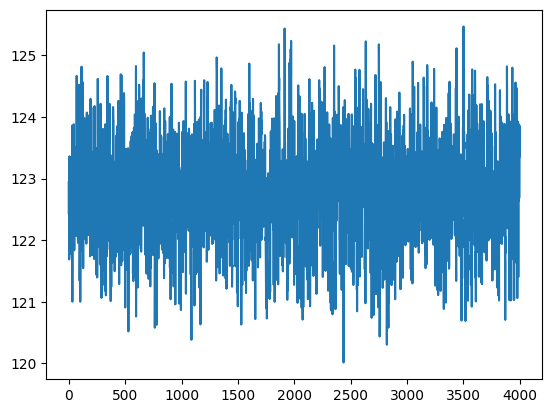

In [97]:
fit11.draws_pd()['theta'].plot()

Mean     122.75700
5%       121.39500
95%      124.07500
R_hat      1.00448
Name: theta, dtype: float64

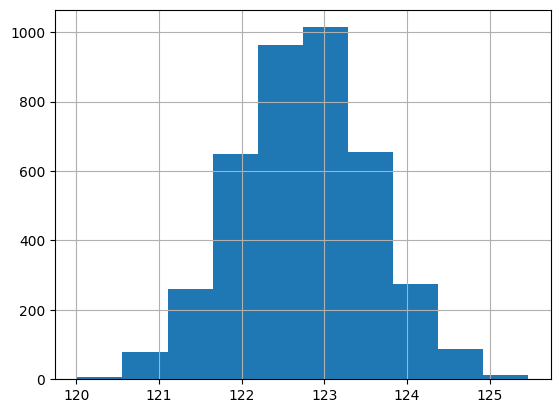

In [98]:
fit11.draws_pd()['theta'].hist()
details11 = fit11.summary()
details11.loc['theta',['Mean', '5%', '95%', 'R_hat']]

In [72]:
road['DriversKilled'].mean()

122.80208333333333

The mean of the posterior (122.757 on last run) is very close to the mean of the dataset (122.802).

4.

Now use `stan` to estimate a slightly reparameterized model. Suppose you want to use a normal prior on an unconstrained parameter. Notice that if something is positive, then the (natural) log of it is unconstrained. Similarly, if something is unconstrained, the exponential of it is positive.

Therefore, use the following model


$$
\theta \sim \text{Normal}(a,b)
$$
and
$$
y_i \mid \theta \sim \text{Poisson}(e^{\theta})
$$

    
Use `stan` to estimate your model for the "DriversKilled" column. Please be sure to 

 - report an $\hat{R}$ diagnostic and comment on whether it is close to $1$
 - display trace plots of your samples obtained and comment on whether they look like "fuzzy caterpillars."

Then, after checking diagnostics...

 - display a histogram of the posterior for $\theta$
 - display a histogram of the posterior for the transformed parameter, too.
 - report estimates of the mean, 5th and 95th percentiles of the posterior of the unconstrained $\theta$
 - comment on whether your posterior mean is close to the frequentist estimator (which is the sample mean of your data)


In [99]:
model_code12 = os.path.join('.', 'hw5q1second.stan')
model12 = CmdStanModel(stan_file=model_code12)

In [100]:
size = len(road)
normal_data = {'n' : size, 'y': road['DriversKilled']}
fit12 = model12.sample(normal_data)

23:13:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

23:13:32 - cmdstanpy - INFO - CmdStan done processing.


<Axes: >

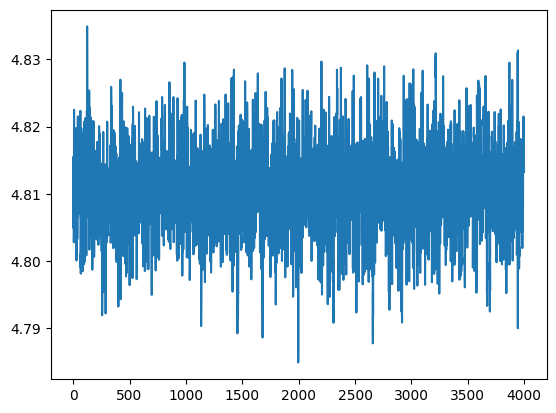

In [101]:
fit12.draws_pd()['theta'].plot()

Mean     4.81051
5%       4.79953
95%      4.82130
R_hat    1.00180
Name: theta, dtype: float64

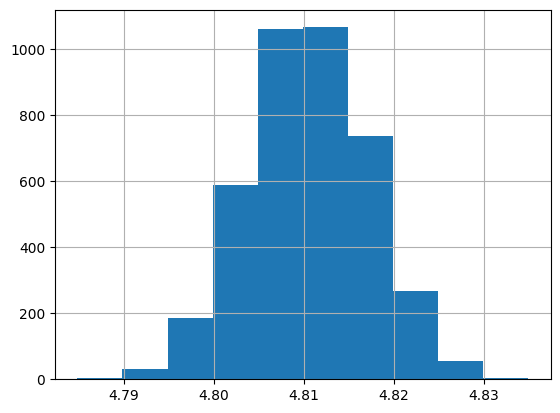

In [102]:
fit12.draws_pd()['theta'].hist()
details12 = fit12.summary()
details12.loc['theta',['Mean', '5%', '95%', 'R_hat']]

In [103]:
np.exp(details12.loc['theta',['Mean']])

Mean    122.794227
Name: theta, dtype: float64

The mean of this posterior distribution is 4.81051 (on last run) which raised to e gives you 122.794227 which is also very close to the mean of the dataset.

### Problem 2: Binomial Data (again!)

Suppose that you have $m > 1$ count data points $y_1, \ldots, y_m$, each having a $\text{Binomial}(n,\eta)$ distribution. Assume further that they're all independent.

Here $n$ is the maximum for each data point. $m$ is the number of data points.

In our second homework we used the beta prior for the parameter that was bounded between $0$ and $1$. 

Now, you must use a normal prior for an unconstrained parameter. 

If $0 < \eta < 1$, then the *logit* transformation is a way to make $-\infty < \theta < \infty$ (unconstrained). Alternatively, if you have $\eta$ that's unconstrained, then the `inv_logit` will squash the value to lie between $0$ and $1$.


`stan` conveniently has a `logit()` and an `inv_logit()` function already made for you.



Use `stan` to estimate your model on any fictitious data you would like. Be sure to

 - report an $\hat{R}$ diagnostic and comment on whether it is close to $1$
 - display trace plots of your samples obtained and comment on whether they look like "fuzzy caterpillars."

Then, after checking diagnostics...

 - display a histogram of the posterior for $\theta$
 - display a histogram of the posterior for the transformed parameter, too.
 - report estimates of the mean, 5th and 95th percentiles of the posterior of the unconstrained $\theta$
 - comment on whether your posterior mean is close to the frequentist estimator (which is the sample mean of your data, again).


In [104]:
model_code2 = os.path.join('.', 'hw5q2ch.stan')
model2 = CmdStanModel(stan_file=model_code2)

23:14:30 - cmdstanpy - INFO - compiling stan file /bml24/hw5q2ch.stan to exe file /bml24/hw5q2ch
23:14:49 - cmdstanpy - INFO - compiled model executable: /bml24/hw5q2ch


In [73]:
num_samps = 100
ar = np.repeat(100, num_samps)
some_fake_data = np.random.binomial(n=ar, p=0.5)
binom_data = {'N' : num_samps, 'y': some_fake_data, 'n': ar}

In [105]:
fit2 = model2.sample(binom_data)

23:14:49 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

23:14:49 - cmdstanpy - INFO - CmdStan done processing.


<Axes: >

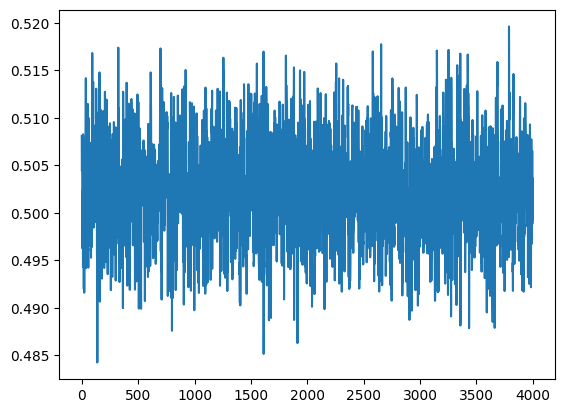

In [106]:
fit2.draws_pd()['theta'].plot()

Mean     0.502308
5%       0.493815
95%      0.510769
R_hat    1.001400
Name: theta, dtype: float64

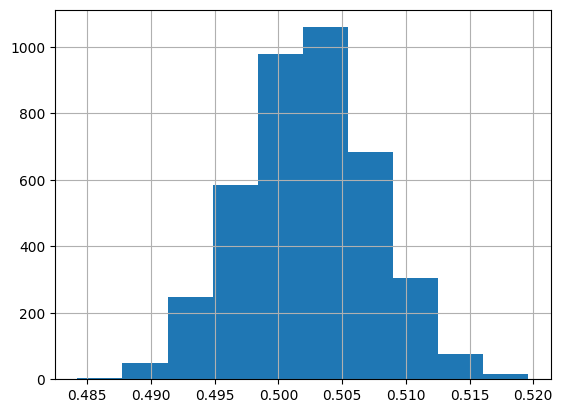

In [107]:
fit2.draws_pd()['theta'].hist()
details2 = fit2.summary()
details2.loc['theta',['Mean', '5%', '95%', 'R_hat']]

In [108]:
some_fake_data.mean()/100

0.5023

The mean of the posterior (0.502308) is very close to the mean of the dataset (.5023).